**Important announcement**

*There is an issue with the calculation of determinism in version 0.0.3 and below; update to version 0.0.4 to receive the fix (pip install --upgrade multiSyncPy). Thanks to @mrrezaie for spotting the issue. Please inform anyone you know who might be using multiSyncPy.*

# Basic usage examples

These examples give a simple introduction to how to use the various functions included in this package to calculate synchrony metrics. For additional information about the parameters and return values for each function, it is also possible to use `help()`. 

In [1]:
import numpy as np
import scipy.spatial
import scipy.signal
import scipy.stats
from matplotlib import pyplot as plt

In [2]:
import multiSyncPy as msp
from multiSyncPy import synchrony_metrics as sm
from multiSyncPy import data_generation as dg

### Generate some data on which to compute the metrics

First off, let's generate some simple test data using the functions that are available.

In [3]:
kuramoto_args = {
    "K":0.5,
    "phases":np.array([0, 0.4*np.pi, 0.8*np.pi, 1.2*np.pi, 1.6*np.pi]),
    "omegas":[1.0,1.5,2.0,2.5, 3.0],
    "alpha":0.5,
    "d_t":0.01,
    "length":1000
}

kuramoto_test_data = dg.kuramoto_data(**kuramoto_args)

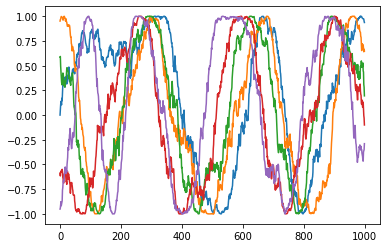

In [4]:
plt.plot(kuramoto_test_data.T)

### Compute metrics

Let's start with the easiest metrics to compute

#### Team-level 'coherence' as defined by Reinero, Dikker, and Bavel

In [5]:
sm.coherence_team(kuramoto_test_data)

0.16012820794111476

#### Pattern entropy

In [6]:
sm.symbolic_entropy(kuramoto_test_data)

3.6359054354330724

#### 'Rho' as defined by Richardson et al.

The next metric, 'rho' (as defined by Richardson et al.), requires us to first convert the data into a phase time series. There are various ways to do so, but the simplest is to obtain the phase time series from the Hilbert transform.

Note also that this metric has two forms: (1) a value at each time step in the input time series (2) an overall value. 

In [7]:
kuramoto_test_data_phases = np.angle(scipy.signal.hilbert(kuramoto_test_data))

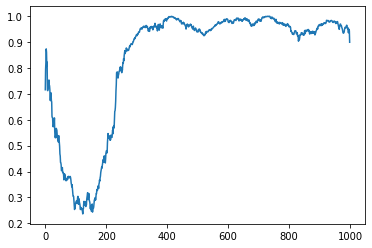

In [8]:
plt.plot(sm.rho(kuramoto_test_data_phases)[0])

In [9]:
sm.rho(kuramoto_test_data_phases)[1]

0.8321676432869842

#### Multidimensional recurrence analysis

The next metric relies upon a recurrence matrix, which effectively states whether the observations at two time steps are sufficiently similar as to be considered the same. Creating this recurrence matrix is relatively simple, but it requires a decision about a 'radius' parameter that defines how similar two observations must be to be considered the same. 

The recurrence analysis actually produces four values:
* proportion of recurrence
* proportion of determinism
* mean diagonal length
* max diagonal length

In [10]:
recurrence_matrix = sm.recurrence_matrix(kuramoto_test_data, radius = 0.5)

sm.rqa_metrics(recurrence_matrix)

(0.022322322322322324, 0.02151751751751752, 9.433164128595601, 999)

#### Kuramoto parameter weak null test

The final metric is somewhat different from the others. Instead of processing a single recording (of multiple participants over time), it processes a population of recordings (which could for example come from running an experiment multiple times). This metric returns a p-value for how likely are the levels of synchrony observed in the sample, compared to random chance. 

Therefore, before computing the metric, we must produce an appropriate sample of test data. 

In [11]:
kuramoto_test_data_sample = np.tile(kuramoto_test_data, (100, 1, 1)) + np.random.normal(0, 0.1, (100, 5, 1000))

kuramoto_test_data_sample = np.angle(scipy.signal.hilbert(kuramoto_test_data_sample))

In [12]:
sm.kuramoto_weak_null(kuramoto_test_data_sample)

(5.665087553527631e-228, 1901.571289478899, 99)

### Windowed metrics

Another facility of the package to demonstrate is the ability to perform a windowed calculation of metrics. Below is an example of computing pattern entropy in windows of size 100 across a dataset of 10000 time steps. 

In [13]:
kuramoto_args = {
    "K":0.5,
    "phases":np.array([0, 0.4*np.pi, 0.8*np.pi, 1.2*np.pi, 1.6*np.pi]),
    "omegas":[1.0,1.5,2.0,2.5, 3.0],
    "alpha":0.5,
    "d_t":0.01,
    "length":10000
}

kuramoto_test_data_long = dg.kuramoto_data(**kuramoto_args)

In [14]:
pattern_entropy_windowed = sm.apply_windowed(kuramoto_test_data_long, 
                                             sm.symbolic_entropy,
                                             100)

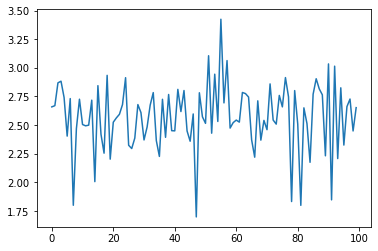

In [15]:
plt.plot(pattern_entropy_windowed)

## Surrogate data

Finally, it is worth showing how to construct surrogate data from a sample, in order to compute baseline results. The code below generates a sample of data and then creates two types of surrogate data: (1) each variable in each time series is cut into windows and the temporal order is shuffled, and (2) the variables themselves are swapped across time series so that they remain the same individually but appear in different combinations in new time series. 

We create a new sample to begin. 

In [16]:
rng = np.random.default_rng() ## random number generator

sample = []

kuramoto_args = {
    "K":2.0,
    "phases":np.array([0, 0.8*np.pi, 1.6*np.pi]),
    "omegas":[1.0,2.0,3.0],
    "alpha":0.5,
    "d_t":0.01,
    "length":1000
}

for i in range(100):
    
    kuramoto_args["omegas"] = rng.exponential(3, (3)) ## Set the natural frequencies to random values
    
    sample.append(dg.kuramoto_data(**kuramoto_args))

sample = np.array(sample)

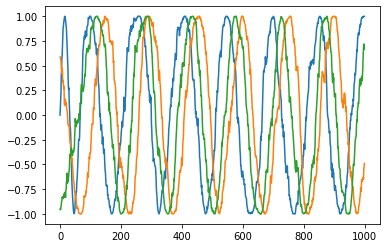

In [17]:
plt.plot(sample[0].T)

Now, surrogate data can be created by shuffling windows. The sample and the length of the window must be provided. 

In [18]:
surrogate_1 = sm.shuffle_time_windows(sample, 100)

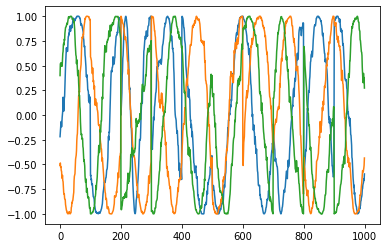

In [19]:
plt.plot(surrogate_1[0].T)

Surrogate data can also be created by swapping variables between time series, as follows.

In [20]:
surrogate_2 = sm.shuffle_recordings(sample)

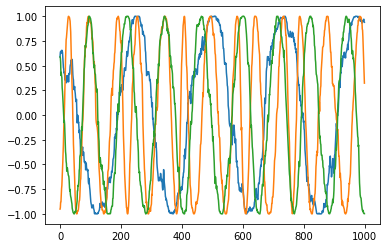

In [21]:
plt.plot(surrogate_2[0].T)